<h3 style="text-align: center;"><b>Сегментация изображений</b></h3>

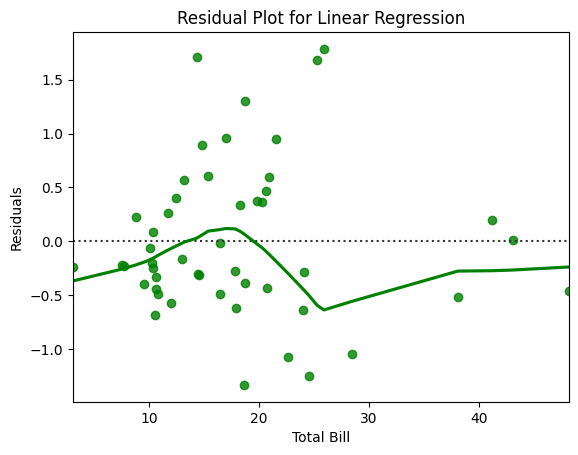

## PyTorch DataLoader

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>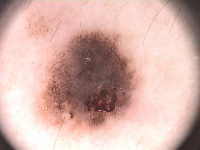</td><td>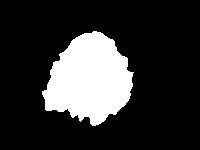</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-12-29 22:47:40--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-12-29 22:47:40--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc97290193421d2410c60d1db570.dl.dropboxusercontent.com/cd/0/inline/CKX-qFXCYg9mS8voMoXgxiUkg1P_3r3QsadiTYVro9YRpETR3Uuu4_E3qkXU1n8N6eL-M6hdRz1GQGYMiT3tbQQea2mkelKAWy3AalBtYrbsIsy3qc6LCb2g1oj-vk2nCN8/file# [following]
--2023-12-29 22:47:41--  https://uc97290193421d2410c60d1db570.dl.dropboxusercontent.com/cd/0/inline/CKX-qFXCYg9mS8voMoXgxiUkg1P_3r3QsadiTYVro9YRpETR3Uuu4_E3qkXU1n8N6eL-M6hdRz1GQGYMiT3tbQQea2mkelKAWy3AalBtYrbsIsy3qc

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
from google.colab import drive
from skimage.io import imread
from skimage.transform import resize
import os
import sys
from IPython.display import clear_output
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (15,4)
from PIL import Image

from time import time
import numpy as np
import copy
from dataclasses import dataclass, asdict
import pickle

drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/ph2/"

Mounted at /content/drive


In [ ]:
images = []
lesions = []

root = drive_path+'PH2Dataset'
for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

In [ ]:
len(lesions)

In [ ]:
# Save arrays to a file
np.save(drive_path+'X.npy', X)
np.save(drive_path+'Y.npy', Y)

In [ ]:
# Load arrays back
loaded_X = np.load(drive_path+'X.npy')
loaded_Y = np.load(drive_path+'Y.npy')

In [ ]:
X = copy.copy(loaded_X)
Y = copy.copy(loaded_Y)

In [ ]:
len(X)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

Разделим наши 200 картинок на 170/30 для обучении теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, ts = np.split(ix, [170])

In [ ]:
print(len(tr), len(ts))

170 30


In [ ]:
X_test = copy.copy(X[ts])
Y_test = copy.copy(Y[ts])

In [ ]:
X = copy.copy(X[tr])
Y = copy.copy(Y[tr])

#### Data Augmentation

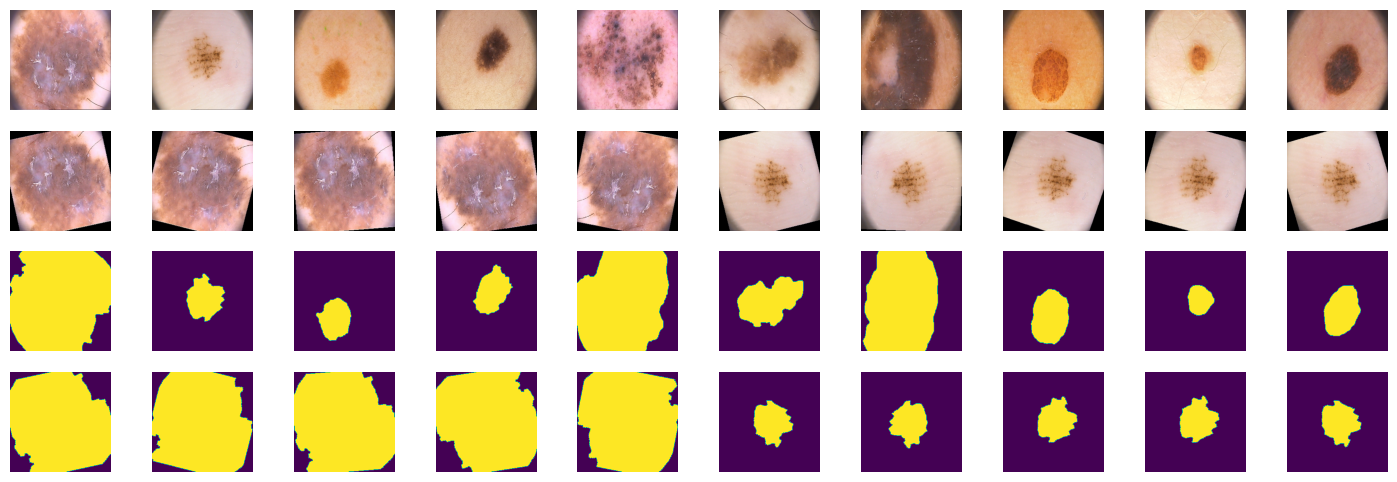

Original dataset shape: (170, 256, 256, 3) (170, 256, 256)
Augmented dataset shape: (850, 256, 256, 3) (850, 256, 256)


In [ ]:
# Define a random transformation using PyTorch transforms with the same seed

def train_transforms(x, seed):
  torch.manual_seed(seed)
  random_transform = transforms.Compose([
      transforms.RandomRotation(degrees=(-25, 25)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      # Другие преобразования, если нужно
  ])

  # Define training transformations using PyTorch transforms
  RESCALE_SIZE = 256  # Change this value based on your requirements
  data_transforms = transforms.Compose([
      random_transform,
      transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
      transforms.ToTensor()
  ])

  return data_transforms(x)

# Apply transformations to your images
transformed_images = []
transformed_labels = []
num_augmentations_per_sample = 5  # Adjust as needed

for img, label in zip(X, Y):
    pil_img = Image.fromarray((img * 255).astype(np.uint8))  # Assuming the input images are in the range [0, 1]
    pil_label = Image.fromarray((label * 255).astype(np.uint8))  # Assuming the input images are in the range [0, 1]
    # Apply the same random transformation to both image and label
    for _ in range(num_augmentations_per_sample):
        # Apply the same random transformation to both image and label
        seed = np.random.randint(0, 2**32)  # Generate a new seed for each iteration
        transformed_img = train_transforms(pil_img, seed)
        transformed_label = train_transforms(pil_label, seed)

        transformed_images.append(transformed_img.numpy())
        transformed_labels.append(transformed_label.numpy())

# Convert the lists of transformed images and labels back to numpy arrays
transformed_images = np.array(transformed_images)
transformed_labels = np.array(transformed_labels)  # Remove singleton dimension

# Move the axis with size 3 to the end
transformed_images = np.moveaxis(transformed_images, 1, -1)
transformed_labels = np.moveaxis(transformed_labels, 1, -1).squeeze()
# Display a few original and transformed images
fig, axes = plt.subplots(4, 10, figsize=(18, 6))

for i in range(10):
    axes[0, i].imshow(X[i])
    axes[0, i].axis("off")

    axes[1, i].imshow(transformed_images[i])
    axes[1, i].axis("off")

    axes[2, i].imshow(Y[i])
    axes[2, i].axis("off")

    axes[3, i].imshow(transformed_labels[i])  # Display single-channel label as grayscale
    axes[3, i].axis("off")

plt.show()

# Check the shape of the augmented dataset
print("Original dataset shape:", X.shape, Y.shape)
print("Augmented dataset shape:", transformed_images.shape, transformed_labels.shape)


In [ ]:
X = np.concatenate((copy.copy(transformed_images), X))
Y = np.concatenate((copy.copy(transformed_labels), Y))

In [ ]:
X.shape

(1020, 256, 256, 3)

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, tv = np.split(ix, [900])

In [ ]:
batch_size = 30

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[tv], 3, 1), Y[tv, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X_test, 3, 1), Y_test[np.arange(len(Y_test)), np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
# Save DataLoader objects
torch.save(data_tr, drive_path+'data_tr.pth')
torch.save(data_val, drive_path+'data_val.pth')
torch.save(data_ts, drive_path+'data_ts.pth')

In [ ]:
# Load DataLoader objects back
data_tr = torch.load(drive_path+'data_tr.pth')
data_val = torch.load(drive_path+'data_val.pth')
data_ts = torch.load(drive_path+'data_ts.pth')

# Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

Эта функция реализует вычисление метрики IoU (Intersection over Union) для сегментации в задачах компьютерного зрения. IoU вычисляется как отношение площади пересечения между предсказанными и истинными масками к общей площади объединения этих масок. Метрика IoU полезна для измерения качества сегментации, особенно в случае, когда у вас есть объекты различных размеров.

# Функция потерь

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Для краткости пусть x = logits = y_prediction = $\hat y$, z = labels = y_real = $y$. Логистические потери составляют:

  z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
  
= z * -log(1 / (1 + exp(-x))) + (1 - z) * -log(exp(-x) / (1 + exp(-x)))

= z * log(1 + exp(-x)) + (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))

= z * log(1 + exp(-x)) + (1 - z) * (x + log(1 + exp(-x))

= (1 - z) * x + log(1 + exp(-x))

= x - x * z + log(1 + exp(-x))

Для x < 0, чтобы избежать переполнения в exp(-x), мы переформулируем приведенное выше

  x - x * z + log(1 + exp(-x))
  
= log(exp(x)) - x * z + log(1 + exp(-x))

= - x * z + log(1 + exp(x))

In [ ]:
def bce_loss_test(y_pred, y_real):
    return nn.BCEWithLogitsLoss()(y_pred, y_real)

def bce_loss(y_pred, y_real):
    return (- y_pred * y_real + torch.log(1 + torch.exp(y_pred))).mean()

# протестируем функцию, сравнив с той, что из коробки
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

bce_loss_test(y_p, y_r), bce_loss(y_p, y_r)       # совпадают

(tensor(0.6646), tensor(0.6646))

# Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(name_model, model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    if is_cuda:
        torch.cuda.empty_cache()
    gc.collect()

    losses = {'train': [], 'valid': []}
    scores = []
    best_score = float('-inf')  # Initialize with negative infinity

    for epoch in range(1, epochs+1):
        tic = time()

        avg_loss = 0
        avg_accuracy = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass

            # backward
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        toc = time()
        losses['train'].append(avg_loss.cpu().detach().numpy())

        # show intermediate results
        model.eval()  # testing mode
        val_loss_avg = 0

        with torch.no_grad():
            for X_val, Y_batch in data_val:
                Y_hat = model(X_val.to(device)).detach().cpu()
                loss_val = loss_fn(Y_hat, Y_batch)
                val_loss_avg += loss_val / len(data_val)

        losses['valid'].append(val_loss_avg.cpu().detach().numpy())
        current_score = score_model(model, iou_pytorch, data_val)
        scores.append(current_score)

        # Save the model if the current score is better than the best score
        if current_score > best_score:
            best_score = current_score
            torch.save(model.state_dict(), drive_path+name_model+'_best_model.pth')

        # Visualize tools
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'{epoch} / {epochs} - val_loss: {avg_loss:.5f}, val_metr: {scores[-1]:.5f}')
        plt.show()
        #scheduler.step()
    return [losses, scores]

# Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device)))
        # используется функция torch.where для бинарной классификации
        Y_pred = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

# Сохранение модели

In [ ]:
@dataclass
class OutData:
    name: str
    history_loss: dict
    scores_in_valid: list
    score_in_valid: float
    score_in_test: float


class OutDataHandle:
    def __init__(
        self,
        name: str,
        history_loss: dict,
        scores_in_valid: list,
        score_in_valid: float,
        score_in_test: float
    ):
        self.out_data = OutData(name, history_loss, scores_in_valid, score_in_valid, score_in_test)

    def get_data(self):
        return asdict(self.out_data)

    def to_pickle(self, path: str = None):
        if path is None:
            full_path = self.out_data.name + '.pkl'
        else:
            full_path = os.path.join(path, self.out_data.name + '.pkl')

        with open(full_path, 'wb') as file:
            pickle.dump(self.get_data(), file)

    @classmethod
    def from_pickle(cls, path: str):
        with open(path, 'rb') as file:
            data = pickle.load(file)
        return cls(**data)

# Реализация различных архитектур

Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

## SegNet

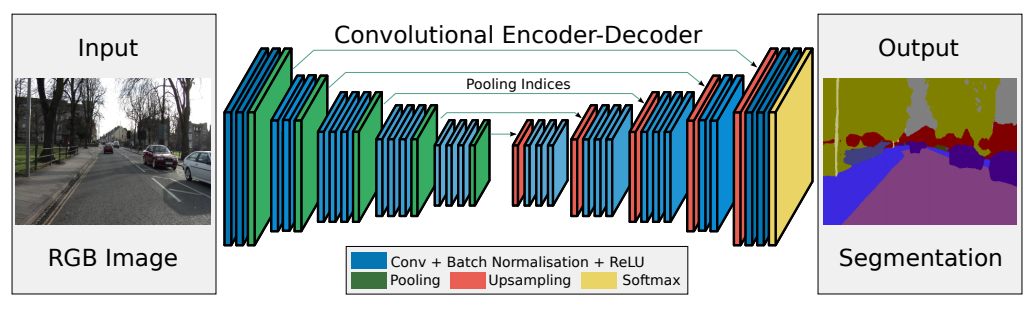

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
class Conv_BN_ReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        super(Conv_BN_ReLU, self).__init__()

        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size,
                stride = stride,
                padding = padding
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_bn_relu(x)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            Conv_BN_ReLU(3, 64),
            Conv_BN_ReLU(64, 64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv1 = nn.Sequential(
            Conv_BN_ReLU(64, 128),
            Conv_BN_ReLU(128, 128)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv2 =  nn.Sequential(
            Conv_BN_ReLU(128, 256),
            Conv_BN_ReLU(256, 256),
            Conv_BN_ReLU(256, 256)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            Conv_BN_ReLU(256, 512),
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)


        # bottleneck
        self.conv_bottleneck = nn.Sequential(
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512)
        )

        self.pool_bottleneck = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool_bottleneck = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_bottleneck = nn.Sequential(
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512)
        )


        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            Conv_BN_ReLU(512, 256),
            Conv_BN_ReLU(256, 256),
            Conv_BN_ReLU(256, 256)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            Conv_BN_ReLU(256, 128),
            Conv_BN_ReLU(128, 128),
            Conv_BN_ReLU(128, 128)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            Conv_BN_ReLU(128, 64),
            Conv_BN_ReLU(64, 64)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            Conv_BN_ReLU(64, 64),
            Conv_BN_ReLU(64, 64),
            nn.Conv2d(
                    in_channels=64,
                    out_channels=1,
                    kernel_size=1,
                    stride=1,
                    padding=0
            )
        )

    def forward(self, x):
        # encoder
        e0, indices0 = self.pool0(self.enc_conv0(x))
        e1, indices1 = self.pool1(self.enc_conv1(e0))
        e2, indices2 = self.pool2(self.enc_conv2(e1))
        e3, indices3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        eb, bottleneck_indices = self.pool_bottleneck(self.conv_bottleneck(e3))
        db = self.dec_bottleneck(self.unpool_bottleneck(eb, bottleneck_indices))

        # decoder
        d0 = self.dec_conv0(self.upsample0(db, indices3))
        d1 = self.dec_conv1(self.upsample1(d0, indices2))
        d2 = self.dec_conv2(self.upsample2(d1, indices1))
        d3 = self.dec_conv3(self.upsample3(d2, indices0))
        return d3

#### SegNet + BCE

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("SegNet + BCE loss")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$



In [ ]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
def dice_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum(y_real * y_pred)
    den = torch.sum(y_real + y_pred)
    res = 1. - (2 *(num/(den or 1)))
    return res

# протестируем функцию, сравнив с той, что из коробки
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

dice_loss_instance = DiceLoss()

dice_loss_instance(y_p, y_r), dice_loss(y_p, y_r)       # совпадают

(tensor(0.4587), tensor(0.4631))

Проводим тестирование:

### SegNet + Dice

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_dice.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history_dice, scores_dice = train('SegNet_Dice', model_dice, optimizer,  dice_loss, max_epochs, data_tr, data_val)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history_dice['train']], label="train")
plt.plot([float(loss) for loss in history_dice['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores_dice, label="score")
plt.title("Score SegNet + Dice loss")
plt.legend()
plt.show()

In [ ]:
score_dice = score_model(model_dice, iou_pytorch, data_val)
score_dice

0.9116667360067368

In [ ]:
test_score_dice = score_model(model_dice, iou_pytorch, data_ts)
test_score_dice

0.7833333611488342

In [ ]:
OutDataHandle("SegNet + Dice loss", history_dice, scores_dice, score_dice, test_score_dice).to_pickle()

### SegNet + Focal

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    """
    Взвешенный пиксельный вариант Энтропии.
    param eps: параметр, ограничивающий сигмоиду снизу,
    чтобы избежать проблем с логарифмом
    param gamma: характерный параметр
    """
    y_real = torch.unsqueeze(y_real, 1)
    y_pred = torch.clamp(torch.sigmoid(torch.unsqueeze(y_pred, 1)), eps, 1)
    result = ((1 - y_pred) ** gamma) * y_real * torch.log(y_pred) + \
              (1 - y_real) * torch.log(1 - y_pred)
    return -torch.mean(result)         # сделаем mean вместо sum, иначе
                                       # астрономические значения Loss


# протестируем функцию
y_r = torch.Tensor(np.random.sample(100).reshape(-1, 1))
y_p = 0.5 * y_r

focal_loss(y_p, y_r)

tensor(0.4558)

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_focal.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history_focal, scores_focal = train('SegNet_Focal', model_focal, optimizer,  focal_loss, max_epochs, data_tr, data_val)

TypeError: ignored

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history_focal['train']], label="train")
plt.plot([float(loss) for loss in history_focal['val']], label="val")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores_focal, label="score")
plt.title("Score SegNet + Focal loss")
plt.legend()
plt.show()

In [ ]:
score_focal = score_model(model_focal, iou_pytorch, data_val)
score_focal

In [ ]:
test_score_focal = score_model(model_focal, iou_pytorch, data_ts)
test_score_focal

In [ ]:
OutDataHandle("SegNet + Focal loss", history_focal, scores_focal, score_focal, test_score_focal).to_pickle()

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
def tversky_loss(y_pred, y_real, alpha=0.3, beta=0.7):
    y_pred = torch.flatten(y_pred.sigmoid())
    y_real = torch.flatten(y_real)

    TP = torch.sum(y_pred * y_real)
    FP = torch.sum((1 - y_real) * y_pred)
    FN = torch.sum(y_real * (1 - y_pred))

    return 1 - TP / ((TP + alpha * FP + beta * FN) or 1)

### SegNet + Tversky

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 100
optimizer = torch.optim.Adam(model_tversky.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history_tversky, scores_tversky = train('SegNet_Tversky', model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history_tversky['train']], label="train")
plt.plot([float(loss) for loss in history_tversky['val']], label="valid")
plt.title("Training Loss SegNet + Tversky loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores_tversky_loss, label="score")
plt.title("Scores SegNet + Tversky loss")
plt.legend()
plt.show()

In [ ]:
score_tversky_loss = score_model(model_tversky_loss, iou_pytorch, data_val)
score_tversky_loss

In [ ]:
test_score_tversky_loss = score_model(model_tversky_loss, iou_pytorch, data_ts)
test_score_tversky_loss

In [ ]:
OutDataHandle("SegNet + Tversky loss", history_tversky_loss, scores_tversky_loss, score_tversky_loss, test_score_tversky_loss).to_pickle()

-----------------------------------------------------------------------------------------

## U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

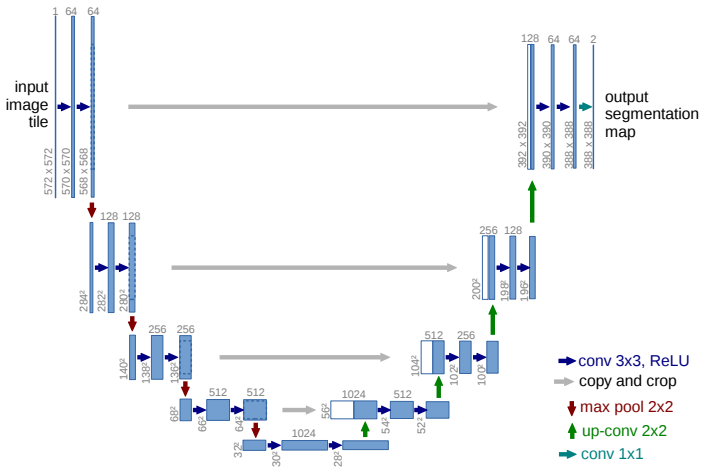

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            Conv_BN_ReLU(3, 64),
            Conv_BN_ReLU(64, 64)
        )
        self.pool0 = nn.MaxPool2d(2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            Conv_BN_ReLU(62, 128),
            Conv_BN_ReLU(128, 128)
        )
        self.pool1 = nn.MaxPool2d(2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            Conv_BN_ReLU(128, 256),
            Conv_BN_ReLU()
        )
        self.pool2 =  # 64 -> 32
        self.enc_conv3 =
        self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck_conv =

        # decoder (upsampling)
        self.upsample0 =  # 16 -> 32
        self.dec_conv0 =
        self.upsample1 =  # 32 -> 64
        self.dec_conv1 =
        self.upsample2 =   # 64 -> 128
        self.dec_conv2 =
        self.upsample3 =   # 128 -> 256
        self.dec_conv3 =

    def forward(self, x):
        # encoder
        e0 =
        e1 =
        e2 =
        e3 =

        # bottleneck
        b =

        # decoder
        d0 =
        d1 =
        d2 =
        d3 =   # no activation
        return d3

In [ ]:
class DoubleConv(nn.Module):
  """ (convolution => [BN] => ReLU) * 2 """

  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding, bias)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size, padding, bias)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

    def forward(self, x):
      return self.double_conv(x)

class Down(nn.Module):
  """ Downscaling with maxpool then double conv """

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """ Upsampling then double conv """

  def __init__(self, in_channels, out_channels, bilinear=False):
    super().__init__()

    #if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
      self.conv = nn.DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)

    #input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x2.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])

    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=False):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = (DoubleConv(n_channels, 64))
    self.down1 = (Down(64, 128))
    self.down2 = (Down(128, 256))
    self.down3 = (Down(256, 512))
    factor = 2 if bilinear else 1
    self.down4 = (Down(512, 1024 // factor))
    self.up1 = (Up(1024, 512 // factor, bilinear))
    self.up2 = (Up(512, 256 // factor, bilinear))
    self.up3 = (Up(256, 128 // factor, bilinear))
    self.up4 = (Up(128, 64, bilinear))
    self.outc = (OutConv(64, n_classes))

  def forward(self, x)
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up2(x, x1)
    logits = self.outc(x)
    return logits

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc_conv0 = nn.Sequential(
        Conv_BN_ReLU(3, 64),
        Conv_BN_ReLU(64, 64)
    )

    self.pool0 = nn.MaxPool2d(2, return_indices=True)

    self.enc_conv1 = nn.Sequential(
        Conv_BN_ReLU(64, 128),
        Conv_BN_ReLU(128, 128)
    )

    self.pool1 = nn.MaxPool2d(2, return_indices=True)

    self.enc_conv2 = nn.Sequential(
        Conv_BN_ReLU(128, 256),
        Conv_Bn_ReLU(256, 256)
    )
    self.pool2 = nn.MaxPool2d(2, return_indices=True)

    self.enc_conv3 = nn.Sequential(
        Conv_BN_ReLU(256, 512),
        Conv_BN_ReLU(512, 512)
    )

    self.pool3 = nn.MaxPool2d(2, return_indices=True)

    self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    #decoder
    self.upsample0 = nn.MaxUnpool2d(2)

    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.upsample1 = nn.MaxUnpool2d(2)

    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.upsample2 = nn.MaxUnpool2d(2)
    self.dec_conv2 = nn.Sequatial(
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2, padding=1),
        nn.BatchNorm2(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=2, padding=1),
        nn.BatchNorm2(128),
        nn.ReLU()
    )

    self.upsample3 = nn.MaxUnpool2d(2)
    self.dec_conv3 = nn.Sequatial(
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
    )

  def forward(self, x):
    #encoder
    ec0 = self.enc_conv0(x)
    e0, i0 = self.pool0(ec0)
    ec1 = self.enc_conv1(e0)
    e1, i1 = self.pool1(ec1)
    ec2 = self.enc_conv2(e1)
    e2, i2 = self.pool2(ec2)
    ec3 = self.enc_conv3(e2)
    e3, i3 = self.pool3(ec3)

    #bottleneck
    b = self.bottleneck_conv(e3)

    #decoder
    d0 = self.dec_conv0(torch.cat((self.upsample0(b, i3), ec3), dim=1))
    d1 = self.dec_conv1(torch.cat((self.upsample1(d0, i2), ec2), dim=1))
    d2 = self.dec_conv2(torch.cat((self.upsample2(d1, i1), ec1), dim=1))
    d3 = self.dec_conv3(torch.cat((self.upsample3(d2, i0), ec0), dim=1))

    #no activation
    return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

### U-Net + BCE

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net + Dice

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net + Focal

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net + Tversky

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

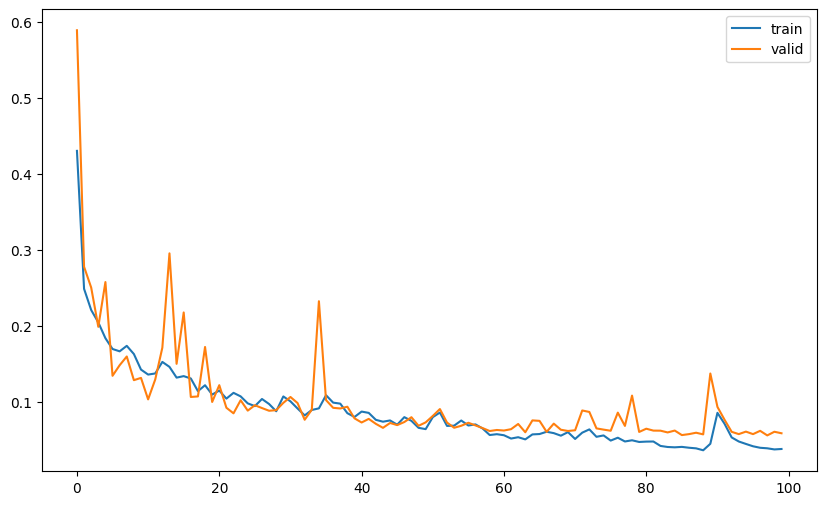

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

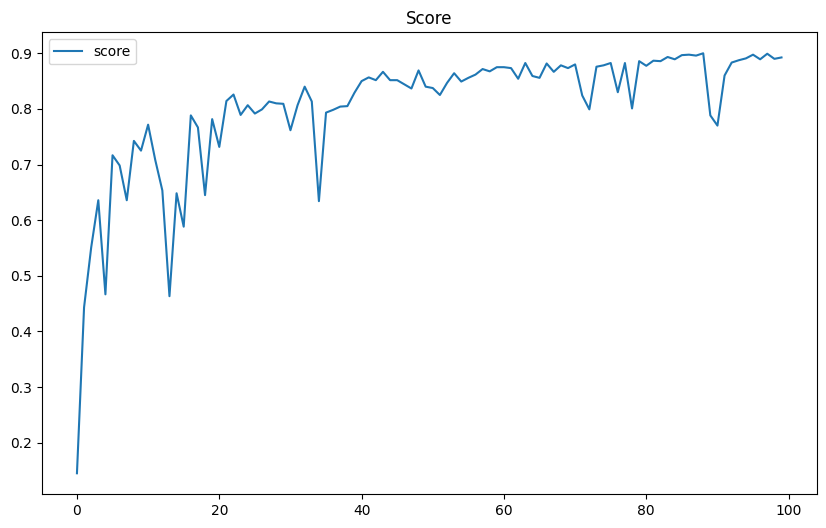

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

## U-Net2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

### U-Net2 + BCE

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net2 + Dice

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net2 + Focal

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

### U-Net2 + Tversky

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()

# Overall Results

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
history, scores = train('SegNet_BCE', model, optimizer,  bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_bce = score_model(model, iou_pytorch, data_val)
score_bce

0.8925000876188278

In [ ]:
test_score_bce = score_model(model, iou_pytorch, data_ts)
test_score_bce

0.7433333396911621

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in history['train']], label="train")
plt.plot([float(loss) for loss in history['valid']], label="valid")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores, label="score")
plt.title("Score")
plt.legend()
plt.show()

In [ ]:
OutDataHandle("SegNet + BCE loss", history, scores, score_bce, test_score_bce).to_pickle()